In [6]:
import numpy as np
import os.path as osp
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models

import faiss

In [62]:
nb_tasks = 7
# ntasks = 31

method = 'er'
# method = 'hoc'

In [63]:
# hyperparameters
checkpoint_path = f'./output/{method}_{nb_tasks}tasks'

batch_size = 128
fixed = True if method == 'hoc' else False
feat_size = 1023 if fixed else 512
increment = 15 if nb_tasks == 7 else 3
replace_ids = [0, 2, 4] if nb_tasks == 7 else [0, 10, 20]
classes_at_task = [10 + increment * i for i in range(nb_tasks)]

In [64]:
## model
class Incremental_ResNet(nn.Module):
  def __init__(self,
               num_classes,
               feat_size, 
               fixed=True,
              ):
    super(Incremental_ResNet, self).__init__()
    self.fixed = fixed
    self.feat_size = feat_size
    backbone = models.resnet18()
    backbone.fc = nn.Identity()
    self.backbone = backbone
    self.fc1 = None
    if self.fixed:
      self.fc1 = nn.Linear(512, feat_size, bias=False)          # junction layer
    self.fc2 = nn.Linear(feat_size, num_classes, bias=False)  # classifier
    if self.fixed:
      self.fc2.weight.requires_grad = False                     # set no gradient for the fixed classifier
      self.fc2.weight.copy_(self.dsimplex(num_classes))         # set the weights for the classifier

  def dsimplex(self, num_classes, device='cuda'):
    def simplex_coordinates_gpu(n, device):
      t = torch.zeros((n + 1, n), device=device)
      torch.eye(n, out=t[:-1,:], device=device)
      val = (1.0 - torch.sqrt(1.0 + torch.tensor([n], device=device))) / n
      t[-1,:].add_(val)
      t.add_(-torch.mean(t, dim=0))
      t.div_(torch.norm(t, p=2, dim=1, keepdim=True)+ 1e-8)
      return t

    feat_size = num_classes - 1
    return simplex_coordinates_gpu(feat_size, device)

  def forward(self, x):
    x = self.backbone(x)
    if self.fc1 is not None:
      x = self.fc1(x)
    y = self.fc2(x)
    return {'logits': y, 'features': x}
  
  def expand_classifier(self, new_classes):
    old_classes = self.fc2.weight.data.shape[0]
    old_weight = self.fc2.weight.data
    self.fc2 = nn.Linear(self.feat_size, old_classes + new_classes, bias=False)
    self.fc2.weight.data[:old_classes] = old_weight

  def resume_weights(self, resume_path):
    print(f"Resuming Weights from {resume_path}")
    new_pretrained_dict = torch.load(resume_path, map_location='cpu')
    if "net" in new_pretrained_dict.keys():
      new_pretrained_dict = new_pretrained_dict["net"]

    if "pretrained" in resume_path:
      state_dict = OrderedDict()
      for k, v in new_pretrained_dict.items():
        name = k.replace('.blocks.', '.')
        if name not in self.state_dict().keys():
          continue
        state_dict[name] = v
      del state_dict['fc2.weight'] # remove classifier weights from iamcl2r pretrained weights
    else:
      state_dict = new_pretrained_dict

    self.load_state_dict(state_dict, strict=False)

In [65]:
# performance metric
def calculate_mAP_gldv2(ranked_gallery_indices, query_gts, topk):
  num_q = ranked_gallery_indices.shape[0]
  average_precision = np.zeros(num_q, dtype=float)
  for i in range(num_q):
    retrieved_indices = np.where(np.in1d(ranked_gallery_indices[i], np.array(query_gts[i])))[0]
    if retrieved_indices.shape[0] > 0:
      retrieved_indices = np.sort(retrieved_indices)
      gts_all_count = min(len(query_gts[i]), topk)
      for j, index in enumerate(retrieved_indices):
        average_precision[i] += (j + 1) * 1.0 / (index + 1)
      average_precision[i] /= gts_all_count
  return np.mean(average_precision)


def image2template_feature(img_feats=None,  # features of all images
                           templates=None,  # target of features in input
                          ):

  unique_templates = np.unique(templates)
  unique_subjectids = None

  template_feats = np.zeros((len(unique_templates), img_feats.shape[1]))

  for count_template, uqt in enumerate(unique_templates):
    ind_t = np.where(templates == uqt)[0]
    face_norm_feats = img_feats[ind_t]
    template_feats[count_template] = np.mean(face_norm_feats, 0)

  template_norm_feats = template_feats / np.sqrt(
      np.sum(template_feats ** 2, -1, keepdims=True))
  return template_norm_feats, unique_templates, unique_subjectids


def calculate_rank(query_feats, gallery_feats, topk):
  num_q, feat_dim = query_feats.shape
  faiss_index = faiss.IndexFlatIP(feat_dim)
  faiss_index.add(gallery_feats)
  _, ranked_gallery_indices = faiss_index.search(query_feats, topk)
  return ranked_gallery_indices


def identification(gallery_feats, gallery_gts, query_feats, query_gts, topk=1):
  # https://github.com/TencentARC/OpenCompatible/blob/master/data_loader/GLDv2.py#L129
  query_gts = np.array(query_gts).reshape(-1, 1)
  unique_gallery_feats, _, _ = image2template_feature(gallery_feats, gallery_gts)
  unique_gallery_feats = unique_gallery_feats.astype(np.float32)

  ranked_gallery_indices = calculate_rank(query_feats, unique_gallery_feats, topk=1)
  mAP = calculate_mAP_gldv2(ranked_gallery_indices, query_gts, topk=1)
  return mAP

In [66]:
# compatibility metrics
def create_position_matrix(matrix=None, **kwargs):
  position = np.zeros_like(matrix, dtype=bool)
  for j in range(matrix.shape[0]):
    for i in range(j + 1, matrix.shape[1]):
      if matrix[i][j] <= matrix[j][j]:
        position[i, j] = True
  return position

def average_compatibility(matrix=None, position=None, **kwargs):
  steps = matrix.shape[0]
  if position is None:
    position = create_position_matrix(matrix)
  max_ac = (steps * (steps-1)) / 2
  if max_ac < 1:
    max_ac = 1
  ac = max_ac - np.sum(position)
  return (1/max_ac) * ac

def replace_zero_with_nan(matrix, **kwargs):
  idx = np.where(matrix == 0)
  matrix[idx] = np.nan
  return matrix

def average_accuracy(matrix=None, per_task=False, **kwargs):
  if max(matrix[-1]) < 1:
    matrix = matrix * 100
  copy_matrix = matrix.copy()
  values = [np.nanmean(replace_zero_with_nan(copy_matrix)[:i+1,:i+1]) for i in range(copy_matrix.shape[0])]

  if per_task:
    return values
  else:
    return values[-1]

In [71]:
# query and gallery loader
transform = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5071, 0.4867, 0.4408),
                                                        (0.2675, 0.2565, 0.2761))
                                    ])
gallery_set = CIFAR10(root='../data', train=False, download=True,
                      transform=transform)
gallery_loader = DataLoader(gallery_set, batch_size=batch_size, shuffle=False,
                            drop_last=False, num_workers=4)

query_set = CIFAR10(root='../data', train=True, download=True,
                    transform=transform)
query_loader = DataLoader(query_set, batch_size=batch_size, shuffle=False,
                          drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [68]:
def extract_features(net, loader):
  features = None
  net.eval()
  with torch.no_grad():
    for inputs in loader:
      images = inputs[0].cuda()
      f = net(images)['features']
      f = F.normalize(f, dim=1)
      features = torch.cat((features, f), 0) if features is not None else f
  return features.detach().cpu().numpy()

In [69]:
# evaluation
compatibility_matrix = np.zeros((nb_tasks, nb_tasks))
query_targets = query_loader.dataset.targets
gallery_targets = gallery_loader.dataset.targets

for task_id in range(nb_tasks):
  ckpt_path = osp.join(*(checkpoint_path, f"ckpt_{task_id}.pt"))
  num_classes = 1024 if fixed else classes_at_task[task_id]
  net = Incremental_ResNet(num_classes=num_classes, feat_size=feat_size, fixed=fixed)
  net.resume_weights(resume_path=ckpt_path)
  net.eval()
  net.cuda()

  query_feat = extract_features(net, query_loader)

  for i in range(task_id+1):
    ckpt_path = osp.join(*(checkpoint_path, f"ckpt_{i}.pt"))
    num_classes = 1024 if fixed else classes_at_task[i]
    previous_net = Incremental_ResNet(num_classes=num_classes, feat_size=feat_size, fixed=fixed)
    previous_net.resume_weights(resume_path=ckpt_path)
    previous_net.eval()
    previous_net.cuda()

    gallery_feat = extract_features(previous_net, gallery_loader)

    acc = identification(gallery_feat, gallery_targets,
                          query_feat, query_targets,
                          topk=1
                        )

    compatibility_matrix[task_id][i] = acc
    if i != task_id:
      acc_str = f'Cross-test between models at task {task_id+1} and {i+1}'
    else:
      acc_str = f'Self-test of model at task {i+1}'
    print(f'{acc_str} 1:N search acc: {acc:.2f}')

print(f"Compatibility Matrix:\n{compatibility_matrix}")

if compatibility_matrix.shape[0] > 1:
  ac = average_compatibility(matrix=compatibility_matrix)
  am = average_accuracy(matrix=compatibility_matrix)

  print(f"AC = {ac:.2f}")
  print(f"AM = {am:.3f}")

Resuming Weights from ./output/er_7tasks/ckpt_0.pt
Resuming Weights from ./output/er_7tasks/ckpt_0.pt
Self-test of model at task 1 1:N search acc: 0.63
Resuming Weights from ./output/er_7tasks/ckpt_1.pt
Resuming Weights from ./output/er_7tasks/ckpt_0.pt
Cross-test between models at task 2 and 1 1:N search acc: 0.62
Resuming Weights from ./output/er_7tasks/ckpt_1.pt
Self-test of model at task 2 1:N search acc: 0.63
Resuming Weights from ./output/er_7tasks/ckpt_2.pt
Resuming Weights from ./output/er_7tasks/ckpt_0.pt
Cross-test between models at task 3 and 1 1:N search acc: 0.12
Resuming Weights from ./output/er_7tasks/ckpt_1.pt
Cross-test between models at task 3 and 2 1:N search acc: 0.11
Resuming Weights from ./output/er_7tasks/ckpt_2.pt
Self-test of model at task 3 1:N search acc: 0.73
Resuming Weights from ./output/er_7tasks/ckpt_3.pt
Resuming Weights from ./output/er_7tasks/ckpt_0.pt
Cross-test between models at task 4 and 1 1:N search acc: 0.11
Resuming Weights from ./output/er_7ta

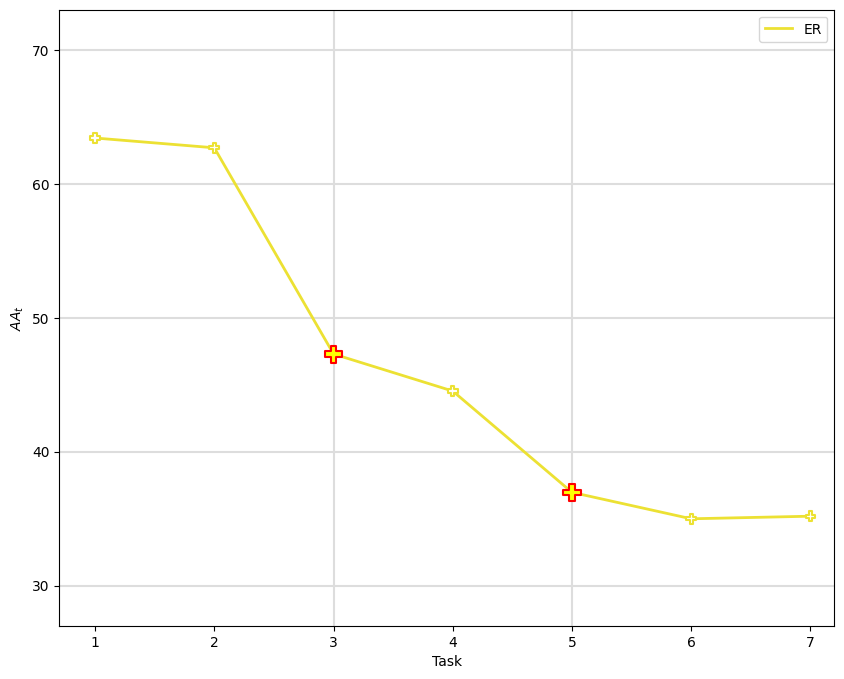

In [70]:
# plot AM per task
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({
    'text.usetex': False,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
plt.rcParams["figure.figsize"] = (10,8)

colors_colorblind = sns.color_palette("colorblind").as_hex()
color = "#D92929" if method == 'hoc' else colors_colorblind[8]
marker = "s" if method == 'hoc' else "P"
legend_label = r"$d$-Simplex-HOC" if method == 'hoc' else r"ER"

values = average_accuracy(matrix=compatibility_matrix, per_task=True)
ntasks = compatibility_matrix.shape[0]

fig, ax = plt.subplots()
replacemenet_ids = replace_ids[1:]
for idx in replacemenet_ids:
  plt.axvline(x=idx+1, color='#DDDDDD', linestyle='solid', lw=1.5, zorder=-5)
plt.grid(axis='y', color='#DDDDDD', linestyle='solid', lw=1.5, zorder=-5)
x = np.arange(1, ntasks+1)

face_colors = ['white' if not i in replacemenet_ids else 'yellow' for i in range(len(x))]
cols = [color if not i in replacemenet_ids else 'red' for i in range(len(x))]
sizes = [150 if i in replacemenet_ids else 50 for i in range(len(x))]

plt.plot(x, values,  color=color, linestyle='solid', lw=2, zorder=2, label=legend_label)
plt.scatter(x, values, s=sizes, marker=marker, edgecolors=cols, lw=1.5, facecolors=face_colors, zorder=2)

plt.xticks(x)
plt.xlim(0.7, ntasks + 0.2)
ax.set_xlabel('Task')
ax.set_ylabel(r'${AA}_{t}$')
plt.legend()
plt.ylim(27, 73)
plt.show()